In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

label_map = {
    'autumn': 0,
    'spring': 1,
    'summer': 2,
    'winter': 3
}

In color_type_clip:

- `clustered_by_color_type_manually_cleaned` was used for training
- `reference` was used for validation 
- `test` for testing

In [242]:
# def images_to_tensors(path, transform):
#     X = []  
#     y = []  

#     for label_name, label_id in label_map.items():
#         folder = os.path.join(path, label_name)
#         print(folder)
#         if not os.path.isdir(folder):
#             continue
#         for filename in os.listdir(folder):
#             if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#                 new_path = os.path.join(folder, filename)
#                 try:
#                     image = Image.open(new_path).convert("RGB")
#                     image_tensor = transform(image)
#                     X.append(image_tensor)
#                     y.append(label_id)
#                 except Exception as e:
#                     print(f"Error with file {new_path}: {e}")

#     X = torch.stack(X)
#     y = torch.tensor(y)
#     return X, y

In [243]:
# # Train and validation datasers load 

# X_train, y_train = images_to_tensors('faces_cleaned_only_augmentated/', transform)
# X_val, y_val = images_to_tensors('reference/', transform)


faces_cleaned_only_augmentated/autumn
faces_cleaned_only_augmentated/spring
faces_cleaned_only_augmentated/summer
faces_cleaned_only_augmentated/winter
reference/autumn
reference/spring
reference/summer
reference/winter


In [5]:
class ColorTypeDataset(Dataset):
    def __init__(self, path, label_map, transform=None):
        self.samples = []
        self.label_map = label_map
        self.transform = transform

        for label_name, label_id in label_map.items():
            folder = os.path.join(path, label_name)
            if not os.path.isdir(folder):
                continue
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(folder, filename), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
train_dataset = ColorTypeDataset('faces_cleaned_only_augmentated/', label_map, transform=train_transform)
val_dataset = ColorTypeDataset('colortypes/', label_map, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 4

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #(16,224,224)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.MaxPool2d(2), #(16,112,112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), #(32,112,112)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), #(64,56,56)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2), #(64,28,28)
            
            # nn.Conv2d(3, 32, kernel_size=3, padding=1), #(32,128,128)
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Conv2d(32, 64, kernel_size=3, padding=1,stride=2), #(64,64,64)
            # nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            # nn.Linear(64 * 64 * 64, 128), 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

weights = torch.tensor([2.937, 7.017, 7.930, 2.558], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total = 0 
    correct = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")


    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = correct / total * 100
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: Val Loss={val_loss/len(val_loader):.4f}, Val Acc={val_acc:.2f}, LR: {optimizer.param_groups[-1]['lr']}")


100%|██████████| 120/120 [00:10<00:00, 11.66it/s]


Epoch [1/10], Loss: 162.4382, Accuracy: 37.54%
Epoch 0: Val Loss=1.4102, Val Acc=19.76, LR: 0.001


100%|██████████| 120/120 [00:09<00:00, 12.40it/s]


Epoch [2/10], Loss: 147.1104, Accuracy: 46.41%
Epoch 1: Val Loss=1.3841, Val Acc=34.68, LR: 0.001


100%|██████████| 120/120 [00:09<00:00, 12.21it/s]


Epoch [3/10], Loss: 134.5890, Accuracy: 52.52%
Epoch 2: Val Loss=1.4600, Val Acc=29.03, LR: 0.001


100%|██████████| 120/120 [00:09<00:00, 12.17it/s]


Epoch [4/10], Loss: 125.3695, Accuracy: 55.22%
Epoch 3: Val Loss=1.4524, Val Acc=33.87, LR: 0.001


100%|██████████| 120/120 [00:09<00:00, 12.43it/s]


Epoch [5/10], Loss: 114.4950, Accuracy: 59.69%
Epoch 4: Val Loss=1.5595, Val Acc=34.27, LR: 0.001


100%|██████████| 120/120 [00:10<00:00, 11.95it/s]


Epoch [6/10], Loss: 104.7229, Accuracy: 63.40%
Epoch 5: Val Loss=1.5106, Val Acc=35.08, LR: 0.0005


100%|██████████| 120/120 [00:09<00:00, 12.53it/s]


Epoch [7/10], Loss: 86.6198, Accuracy: 68.92%
Epoch 6: Val Loss=1.6255, Val Acc=35.89, LR: 0.0005


100%|██████████| 120/120 [00:09<00:00, 12.29it/s]


Epoch [8/10], Loss: 77.2443, Accuracy: 72.94%
Epoch 7: Val Loss=1.7263, Val Acc=33.47, LR: 0.0005


100%|██████████| 120/120 [00:09<00:00, 12.34it/s]


Epoch [9/10], Loss: 69.8350, Accuracy: 76.08%
Epoch 8: Val Loss=1.8828, Val Acc=38.31, LR: 0.0005


100%|██████████| 120/120 [00:09<00:00, 12.55it/s]


Epoch [10/10], Loss: 59.9011, Accuracy: 79.48%
Epoch 9: Val Loss=1.9364, Val Acc=33.06, LR: 0.00025


In [24]:
test_dataset = ColorTypeDataset('colortypes_cleaned_back/', label_map, transform=val_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
model.eval()
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())

In [26]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


              precision    recall  f1-score   support

      autumn       0.35      0.33      0.34        67
      spring       0.38      0.43      0.40        63
      summer       0.45      0.33      0.38        39
      winter       0.53      0.58      0.56        79

    accuracy                           0.44       248
   macro avg       0.43      0.42      0.42       248
weighted avg       0.43      0.44      0.43       248



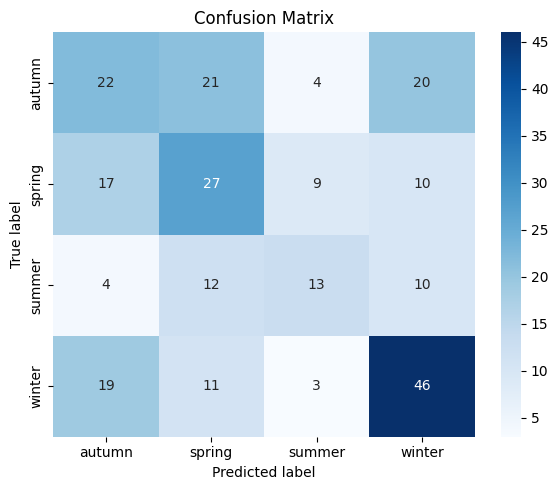

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Объединяем все батчи в один массив
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Строим confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = list(label_map.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


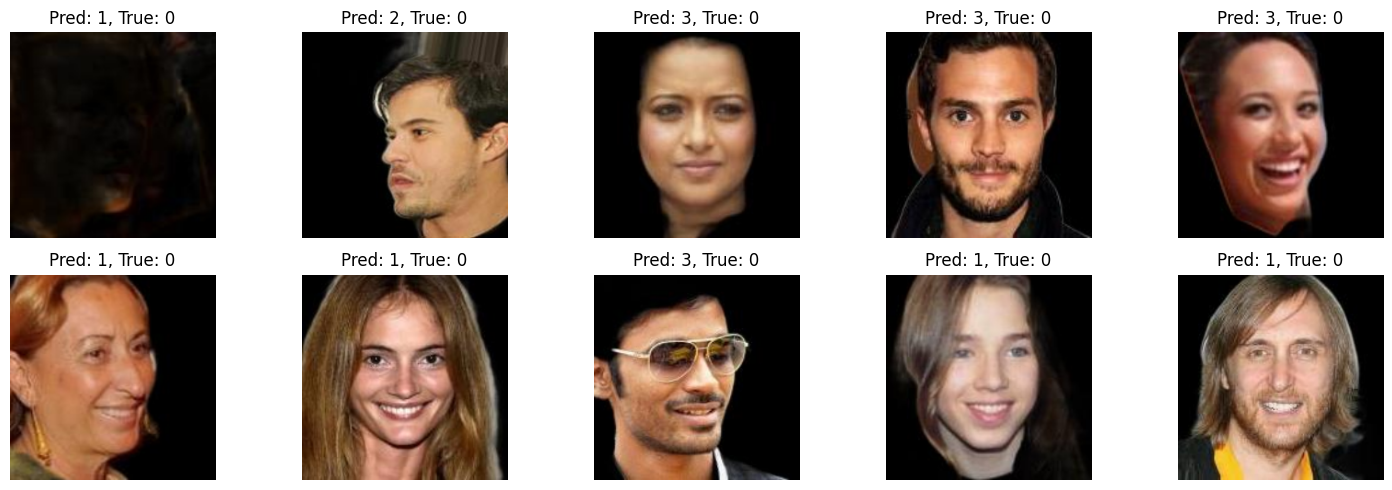

In [28]:
import matplotlib.pyplot as plt

model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        wrong_mask = predicted != labels
        if wrong_mask.any():
            wrong_images.append(images[wrong_mask].cpu())
            wrong_preds.extend(predicted[wrong_mask].cpu().tolist())
            wrong_labels.extend(labels[wrong_mask].cpu().tolist())

if wrong_images:
    wrong_images = torch.cat(wrong_images)

    num_display = min(10, len(wrong_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_display):
        img = wrong_images[i].permute(1, 2, 0).numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {wrong_preds[i]}, True: {wrong_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Error.")


In [237]:
import joblib

joblib.dump(model, 'cnn_model.pkl')

['cnn_model.pkl']

In [245]:
X_test, y_test = images_to_tensors('DATASET', transform)


DATASET/autumn
DATASET/spring
DATASET/summer
DATASET/winter


In [248]:
# for validation data 

with torch.no_grad():
    X_test = X_test.to(device)
    outputs = model(X_test)
    _, y_pred = torch.max(outputs, 1)
    
print(classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy(), target_names=label_map.keys()))


              precision    recall  f1-score   support

      autumn       0.40      0.40      0.40        50
      spring       0.37      0.21      0.27        52
      summer       0.29      0.39      0.33        51
      winter       0.58      0.63      0.60        51

    accuracy                           0.41       204
   macro avg       0.41      0.41      0.40       204
weighted avg       0.41      0.41      0.40       204



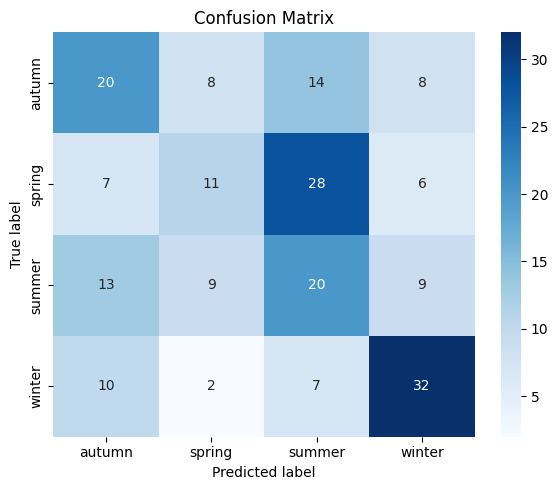

In [249]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
labels = list(label_map.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()